[*********************100%***********************]  5 of 5 completed
<ipython-input-13-d2b8ffb7a7fa>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Missing Data Check: 
 Ticker
AAPL     0
DIS      0
GOOGL    0
PFE      0
XOM      0
dtype: int64

Correlation Matrix: 
 Ticker      AAPL       DIS     GOOGL       PFE       XOM
Ticker                                                  
AAPL    1.000000  0.438655  0.648932  0.285310  0.281849
DIS     0.438655  1.000000  0.451513  0.234788  0.443689
GOOGL   0.648932  0.451513  1.000000  0.252657  0.259573
PFE     0.285310  0.234788  0.252657  1.000000  0.244490
XOM     0.281849  0.443689  0.259573  0.244490  1.000000

Optimal Portfolio Weights (Max Sharpe Ratio):
AAPL: 0.40
GOOGL: 0.00
DIS: 0.36
XOM: 0.00
PFE: 0.24

Optimal Portfolio (Max Sharpe Ratio): Return: 0.2577, Volatility: 0.2581, Sharpe Ratio: 0.8434

Optimal Portfolio Weights (Minimum Volatility):
AAPL: 0.15
GOOGL: 0.11
DIS: 0.15
XOM: 0.40
PFE: 0.19

Optimal Portfolio (Minimum Volatility): Return: 0.1248, Volatility: 0.2128


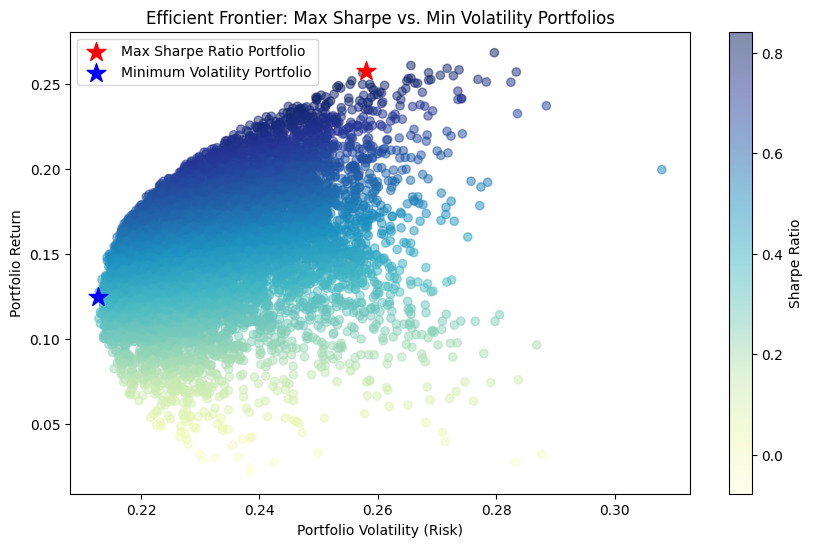

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

# Define a more diversified set of stock tickers
tickers = ['AAPL', 'GOOGL', 'DIS', 'XOM', 'PFE']

# Download historical adjusted close price data
data = yf.download(tickers, start='2020-01-01', end='2025-01-01')['Close']

# Fill missing data forward
data.fillna(method='ffill', inplace=True)

# Check for missing data
print("Missing Data Check: \n", data.isnull().sum())

# Calculate daily returns
returns = data.pct_change().dropna()

# Check for correlation matrix
print("\nCorrelation Matrix: \n", returns.corr())

# Calculate annualized mean returns and covariance matrix
mean_returns = returns.mean() * 252  # Annualized expected returns
cov_matrix = returns.cov() * 252  # Annualized covariance matrix

# Define risk-free rate (annualized)
risk_free_rate = 0.04  # 4% annual rate

# Portfolio performance calculation (return, volatility, Sharpe ratio)
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, mean_returns)  # Annualized portfolio return
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Annualized volatility
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility if port_volatility > 0 else 0
    return np.array([port_return, port_volatility, sharpe_ratio])

# Objective function to minimize (negative Sharpe ratio)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]  # Negative Sharpe ratio

# Objective function to minimize volatility (for minimum variance portfolio)
def min_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[1]  # Portfolio volatility

# Constraints (weights must sum to 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds (each weight between 0 and 0.4, no short-selling)
bounds = tuple((0, 0.4) for _ in range(len(tickers)))  # Restrict maximum weight to 40%

# Initial guess (equal weights)
init_guess = len(tickers) * [1. / len(tickers)]

# Safety check for Sharpe ratio optimization
if (mean_returns < risk_free_rate).all():
    print("Warning: All expected returns are below the risk-free rate. Optimization may not yield meaningful results.")
else:
    # Run the optimization to maximize the Sharpe ratio
    optimal_sharpe = sco.minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                                  method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights_sharpe = optimal_sharpe.x
    opt_sharpe_return, opt_sharpe_volatility, opt_sharpe_ratio = portfolio_performance(optimal_weights_sharpe, mean_returns, cov_matrix, risk_free_rate)

    # Run the optimization for minimum variance portfolio
    optimal_min_vol = sco.minimize(min_volatility, init_guess, args=(mean_returns, cov_matrix),
                                   method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights_min_vol = optimal_min_vol.x
    opt_min_vol_return, opt_min_volatility, _ = portfolio_performance(optimal_weights_min_vol, mean_returns, cov_matrix, risk_free_rate)

    # Display the optimal portfolio details
    print("\nOptimal Portfolio Weights (Max Sharpe Ratio):")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {optimal_weights_sharpe[i]:.2f}")

    print(f"\nOptimal Portfolio (Max Sharpe Ratio): Return: {opt_sharpe_return:.4f}, Volatility: {opt_sharpe_volatility:.4f}, Sharpe Ratio: {opt_sharpe_ratio:.4f}")

    print("\nOptimal Portfolio Weights (Minimum Volatility):")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {optimal_weights_min_vol[i]:.2f}")

    print(f"\nOptimal Portfolio (Minimum Volatility): Return: {opt_min_vol_return:.4f}, Volatility: {opt_min_volatility:.4f}")

    # Simulate random portfolios to visualize the efficient frontier
    num_portfolios = 10000
    portfolio_returns = np.zeros(num_portfolios)
    portfolio_volatility = np.zeros(num_portfolios)
    sharpe_ratios = np.zeros(num_portfolios)
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)  # Normalize the weights to sum to 1

        # Calculate portfolio return and volatility
        portfolio_returns[i] = np.sum(weights * mean_returns)  # Annualized return
        portfolio_volatility[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Annualized volatility

        # Calculate Sharpe ratio
        sharpe_ratios[i] = (portfolio_returns[i] - risk_free_rate) / portfolio_volatility[i] if portfolio_volatility[i] > 0 else 0

        weights_record.append(weights)

    # Plot random portfolios and the efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_volatility, portfolio_returns, c=sharpe_ratios, cmap='YlGnBu', marker='o', alpha=0.5)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Portfolio Volatility (Risk)')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier: Max Sharpe vs. Min Volatility Portfolios')

    # Highlight optimal portfolios
    plt.scatter(opt_sharpe_volatility, opt_sharpe_return, color='red', marker='*', s=200, label='Max Sharpe Ratio Portfolio')
    plt.scatter(opt_min_volatility, opt_min_vol_return, color='blue', marker='*', s=200, label='Minimum Volatility Portfolio')

    plt.legend()
    plt.show()
